## Лабораторная работа №3.

Дедлайн: 21 мая 23:59

### Часть 1. Overfit it (1.5 points)

Будем работать с датасетом [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) (*hint: он доступен в torchvision*).

Ваша задача состоит в следующем:
1. Обучить сеть, которая покажет >= 0.94 test accuracy.
2. Пронаблюдать и продемонстрировать процесс переобучения сети с увеличением числа параметров (==нейронов) и продемонстрировать это наглядно (например, на графиках).
3. Попробовать частично справиться с переобучением с помощью подходящих приемов (Dropout/batchnorm/augmentation etc.)

*Примечание*: Пункты 2 и 3 взаимосвязаны, в п.3 Вам прелагается сделать полученную в п.2 сеть менее склонной к переобучению. Пункт 1 является независимым от пунктов 2 и 3.

In [1]:
# Your great code here
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms

from IPython.display import clear_output
import time
from tqdm import tqdm_notebook as tqdm

%matplotlib inline
%reload_ext autoreload
%autoreload 2

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
### Let's have a cell with global hyperparameters for the CNNs in this notebook

# Number of threads for data loader
NUM_WORKERS = 4

# Image size: even though image sizes are bigger than 96, we use this to speed up training
SIZE_H = SIZE_W = 28

# Number of classes in the dataset
NUM_CLASSES = 10

# Epochs: number of passes over the training data, we use it this small to reduce training babysitting time
EPOCH_NUM = 40

# Batch size: for batch gradient descent optimization, usually selected as 2**K elements
BATCH_SIZE = 64

# Last layer (embeddings) size for CNN models
EMBEDDING_SIZE = 512

# Images mean and std channelwise
image_mean = [0.2860]
image_std  = [0.3202]
# image_mean = [0]
# image_std  = [255]

In [3]:
english_labels = ["T-shirt/top",
                  "Trouser",
                  "Pullover",
                  "Dress",
                  "Coat",
                  "Sandal",
                  "Shirt",
                  "Sneaker",
                  "Bag",
                  "Ankle boot"]

## Use `norm = False` to count image_mean and image_std
norm = True
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=image_mean,
                                                    std=image_std)])

train_data = datasets.FashionMNIST('data', train=True, download=False,
                                   transform=transform if norm else transforms.ToTensor())

test_data = datasets.FashionMNIST('data', train=False, download=True,
                                  transform=transform if norm else transforms.ToTensor())

train_loader = DataLoader(train_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True if norm else False, 
                          num_workers=NUM_WORKERS)

test_loader = DataLoader(test_data, 
                         batch_size=BATCH_SIZE,
                         shuffle=True,
                         num_workers=NUM_WORKERS)

In [4]:
len(train_loader.dataset), len(test_loader.dataset)

(60000, 10000)

In [5]:
# # Count mean for each channel. Assume t.shape == (batch_size, channels, h, w)
# torch[t.shape for t, c in train_loader]
# image_means = torch.stack([torch.mean(t, (0,2,3)) for t, c in train_loader])
# image_means = torch.mean(image_means, 0)
# # # # torch.stack([print(t.shape) for t, c in train_dataset])
# torch.mean(image_means, 0)

# # Count std for each channel. Assume t.shape == (batch_size, channels, h, w)
# image_std = torch.stack([torch.sqrt(
#         torch.mean((t - torch.mean(t, (0,2,3), keepdim=True))**2, (0,2,3))) for t, c in train_loader])
# image_std = torch.sum(image_std) / len(train_loader)

torch.Size([1, 28, 28])
6 Shirt


NameError: name 'get_cmap' is not defined

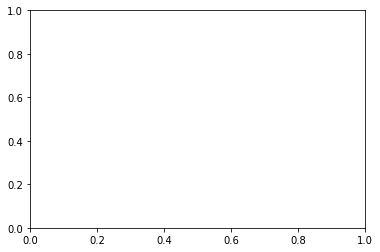

In [6]:
# Let's take a look at our data

img, target = train_data[56]
# channel x width x height
print(img.shape)
print(target, english_labels[target])

fig, ax = plt.subplots(1, 1)
ax.imshow(img[0].numpy(), cmap=get_cmap('gray'))
plt.show()

In [7]:
import matplotlib
matplotlib.__version__

'3.0.3'

In [8]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # _ x 1 x 28 x 28
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            # _ x 20 x 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            # _ x 20 x 14 x 14

            
            nn.Conv2d(32, 64, 3, padding=1),
            # _ x 32 x 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
            # _ x 32 x 7 x 7    
        )

        self.fc = nn.Sequential(
            # this converts our 2D feature maps to 1D feature vectors
            Flatten(),
            # _ x 64 * 7 * 7 
            nn.Linear(64 * 7 * 7, EMBEDDING_SIZE),
#             nn.BatchNorm1d(EMBEDDING_SIZE),
            # _ x EMBEDDING_SIZE
            nn.ReLU()
        )
        
        self.pred = nn.Sequential(
            nn.Linear(EMBEDDING_SIZE, NUM_CLASSES),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        x = self.pred(x)
        return x
        
    def reset_parameters(self):
        for module in self.model:
            try:
                module.reset_parameters()
            except AttributeError:
                pass
            
        for module in self.fc:
            try:
                module.reset_parameters()
            except AttributeError:
                pass
                
        for module in self.pred:
            try:
                module.reset_parameters()
            except AttributeError:  
                pass

In [9]:
def train_model(model, train_batch_generator, val_batch_generator, 
                opt=None, ckpt_name=None, n_epochs=EPOCH_NUM, 
                annealing=False, verbose=True):
    if verbose:
        print("Train on {} samples, validate on {}".format(len(train_batch_generator.dataset), 
                                                           len(val_batch_generator.dataset)))
    
    logs = {'epoch': [], 'train_loss': [], 'val_loss': [],
        'val_accuracy': [],'top_val_accuracy' : 0, 'lr': []}
    
    best_model = None
    iteration = 0
    top_val_accuracy = 0
    
    if opt:
        optimizer=opt
    else:
        optimizer = torch.optim.SGD(model.parameters(), 
                                    lr=0.001, 
                                    weight_decay=0.0001, 
                                    momentum=0.9)
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
#     criterion = nn.NLLLoss(reduction='mean')

    for epoch in range(n_epochs):
        train_loss = []
        val_loss = []
        val_accuracy = []
        start_time = time.time()
        
        if epoch == 20 and annealing:
            optimizer.param_groups[0]['lr'] *= .1  
        elif epoch == 45 and annealing:
            optimizer.param_groups[0]['lr'] *= .1
        
        # TRAIN
        model.train(True) # enable dropout / batch_norm training behavior
        for (X_batch, y_batch) in tqdm(train_batch_generator, desc='Training'):
            # move data to target device
            assert len(X_batch) == len(y_batch)
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # train on batch: compute loss, calc grads, perform optimizer step
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()    
            optimizer.step()

            train_loss.append(loss.cpu().data.numpy())
            
#             if annealing: scheduler.step(epoch)

        # TEST / VALIDATE
        model.train(False) # disable dropout / use averages for batch_norm
        for X_batch, y_batch in val_batch_generator:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # compute logits
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            val_loss.append(loss.cpu().data.numpy())
            
            y_pred = logits.max(1)[1].data
            val_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))
            
#         clear_output(wait=True)
        # print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, n_epochs, time.time() - start_time))
        

        train_loss_value = np.mean(train_loss)
        val_accuracy_value = np.mean(val_accuracy) * 100
        
        #Crutch to add parameter to the model
#         model.register_buffer('val_accuracy', torch.Tensor([val_accuracy_value]))
        
        if val_accuracy_value > top_val_accuracy and ckpt_name is not None:
            top_val_accuracy = val_accuracy_value
            # print('top val accuracy: %.3f' % top_val_accuracy)
            # save checkpoint of the best model to disk
#             if not COLAB:
#                 with open(ckpt_name, 'wb') as f: torch.save(model, f)
#             else:
#                 with open(models_dir + ckpt_name, 'wb') as f: torch.save(model, f)
        
        logs['epoch'].append(epoch)
        logs['train_loss'].append(train_loss_value)
        logs['val_loss'].append(np.mean(val_loss))
        logs['val_accuracy'].append(val_accuracy_value)
        logs['lr'].append(optimizer.param_groups[0]['lr'])

        print("  training loss (in-iteration): \t{:.6f}".format(logs['train_loss'][-1]))
        print("  validation accuracy: \t\t\t{:.2f} %".format(logs['val_accuracy'][-1]))
        
        custom_objects = (logs, )
        
    # Load best model found during trainig
#     if ckpt_name is not None:
#         if not COLAB:
#             with open(ckpt_name, 'rb') as f: best_model = torch.load(f)
#         else:
#             with open(models_dir + ckpt_name, 'rb') as f: best_model = torch.load(f)
   
    return best_model, opt, custom_objects


In [ ]:
model = SimpleCNN()
lr = 3e-4
opt = torch.optim.Adam(model.parameters(), 
                       lr=lr, 
                       betas=(0.9, 0.99), 
                       eps=1e-08, 
                       weight_decay=0)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                       T_max=3,
                                                       last_epoch=-1)

In [ ]:
bm, optim, custom_obj = train_model(model, train_loader, test_loader, opt, n_epochs=30, verbose=False)

In [ ]:
logs = custom_obj[0]

In [ ]:
# print(model)
ckpt_name = 'fashion_mnist_overfited'
models_dir = './'
with open(models_dir + ckpt_name, 'wb') as f: torch.save(model, f)

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(logs['epoch'], logs['val_loss'],'g-', label='validation')
plt.plot(logs['epoch'], logs['train_loss'], label = 'train')
plt.legend()
plt.subplot(1, 2, 2)
# fig, ax = plt.subplots(2, 2)
plt.plot(logs['epoch'], logs['val_accuracy'],'g-')

### Часть 2. Almost Shakespeare (1.5 points)

В этой части задания мы научимся генерировать текст с помощью нейронных сетей. Конкретнее, обучим нейронную сеть на сонетах Шекспира и попросим нейросеть написать свой сонет.

Генерация текста обычно включает в себя следующие шаги:
    
1. Загрузка данных.
2. Создание словарей слов/символов.
3. Препроцессинг данных.
4. Обучение модели (нейросети).
5. Генерация нового текста.


#### Часть 1. Предобработка данных

Для начала загрузим данные. Файл с сонетами Шекспира доступен по [ссылке](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). Кроме того, он находится рядом с этим ноутбуком (`sonnetes.txt`).

Базовая предобработка уже сделана: текст состоит непосредственно из поэм Шекспира и названий/номеров глав, все техническая информация удалена.

In [ ]:
with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START:TEXT_END]
assert len(text) == 2616

Так как в этот раз мы хотим научиться предсказывать текст, понизим сложность задачи и приведем текст к нижнему регистру.

В настоящий момент переменная `text` представляет собой список из строк. Объедините все строки в одну и приведите к нижнему регистру. 

In [ ]:
# Объедините все строки в одну и приведите к нижнему регистру.
# Результат запишите в переменную text.

# Your great code here

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('Отлично!')

Выделите множество всех символов, с которыми нам довелось встретиться в переменную `tokens`.

In [ ]:
tokens = sorted(set(text))

Постройте словарь `token_to_idx` вида <символ>: <индекс> и словарь `idx_to_token` вида <индекс>: <символ>.

In [ ]:
# словарь вида <индекс>:<символ>
# Your great code here

# словарь вида <символ>:<индекс>
# Your great code here

*Комментарий: т.к. у нас всего 38 различных токенов, в этот раз воспользуемся one-hot encoding'ом.*


## Построение модели.

Теперь наша задача - создать и обучить рекуррентную нейронную сеть, которая сможет генерировать что-то похожее на поэзию Шекспира.

Для начала воспользуемся классической RNN, аналогичной построенной на семинаре. 

In [ ]:
# Your modified code from class here

Постройте график функции потерь в зависимости от номера эпохи.

In [ ]:
# Your plot code here

In [ ]:
# Пример сгенерированного текста. Функция `generate_text` отсутствует в коде выше.
# print(generate_text(length=500, temperature=0.2))

### Более поэтичная модель

Теперь давайте воспользуемся LSTM слоем вместо классической RNN и сравним результаты.

Снова постройте график функции потерь от числа эпох. Стал ли финальный loss лучше?

In [ ]:
# Your beautiful code here

Сгенерируйте текст с помощью обученной сети для различных значений параметра `temperature`: `[0.1, 0.2, 0.5, 1.0, 2.0]` ("температуры" при генерации). Оцените результаты визуально, попробуйте их проинтерпретировать.

In [ ]:
# Text generation with different tempearature values here

Здесь можно оставить свои рассуждения касательно интерпретации результатов.

#### Сохранение и загрузка модели

Сохраните обученную модель на диск, затем загрузите ее и сгенерируйте текст. Примеры доступны по [ссылке](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
# Saving and loading code here

Данная часть задания завершена.

#### Полезные ссылки
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Статья Андрея Карпатого про RNN. </a> В качестве примеров рассматриваются задачи генерации Шекспировских текстов, Latex формул, Linux Source Code и детских имен.
2. <a href='https://github.com/karpathy/char-rnn'> Репозиторий с кодом по char-rnn </a> (тоже за авторством Андрея Карпатого)
3. Полезный репозиторий по PyTorch: [ссылка](https://github.com/spro/practical-pytorch`)

____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________

Части задания 3 (HAR classification) и 4 (kaggle) доступны на выбор. Вы можете выполнить одну из них, или обе.

### Часть 3. HAR classification with raw data (2+ points)
__Disclaimer__: В данном задании придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

%matplotlib inline

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

In [ ]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [ ]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

In [ ]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 85%.__
Разбалловка следующая:
* $=$85% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

In [ ]:
# Your experiments here

### Часть 4. Birds classification.
На kagge доступно [in-class соревнование](https://www.kaggle.com/c/bird-classification3/overview), проводившееся для студентов ШАДа. 

Ваше задание: научиться классифицировать изображения птиц. Вы можете обучить сеть с нуля или же воспользоваться fine-tunning'ом. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).
Разбаловка следующая:
* $=$80% - 2 points
* $>=$81.5% - 2.5 points
* $>=$82.8% - 3 points

In [ ]:
# Your code here